# Correlation function of DR72 SDSS VAGC Catalog

First import all the modules such as healpy and astropy needed for analyzing the structure

In [1]:
import healpix_util as hu
import astropy as ap
import numpy as np
from astropy.io import fits
from astropy.table import Table
import astropy.io.ascii as ascii
from astropy.io import fits
from astropy.constants import c
import matplotlib.pyplot as plt
import math as m
from math import pi
import scipy.special as sp
from astroML.decorators import pickle_results
from scipy import integrate
import warnings
from sklearn.neighbors import BallTree
import pickle
import multiprocessing as mp
import time
#from cython_metric import *
from lcdmmetric import *
from progressbar import *
from tqdm import *
from functools import partial
import pymangle
from scipy.stats import gaussian_kde
from __future__ import division
#from astroML.datasets import fetch_sdss_specgals
#from astroML.correlation import bootstrap_two_point_angular
%matplotlib inline

In [2]:
def kde(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)


def generate_rand_from_pdf(pdf, x_grid, N):
    cdf = np.cumsum(pdf)
    cdf = cdf / cdf[-1]
    values = np.random.rand(N)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = x_grid[value_bins]
    return random_from_cdf

In [7]:
def run():
    data = np.random.normal(size=1000)
    hist, bins = np.histogram(data, bins=50)

    x_grid = np.linspace(min(data), max(data), 1000)
    kdepdf = kde(data, x_grid, bandwidth=0.1)
    random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, N=10000)

    bin_midpoints = bins[:-1] + np.diff(bins) / 2
    random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, 10000)

    plt.subplot(121)
    plt.hist(data, 50, normed=True, alpha=0.5, label='hist')
    plt.plot(x_grid, kdepdf, color='r', alpha=0.5, lw=3, label='kde')
    plt.legend()
    plt.subplot(122)
    plt.hist(random_from_cdf, 50, alpha=0.5, label='from hist')
    plt.hist(random_from_kde, 50, alpha=0.5, label='from kde')
    plt.legend()
    plt.show()

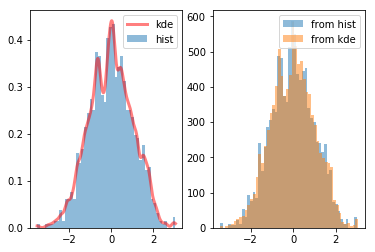

In [8]:
run()

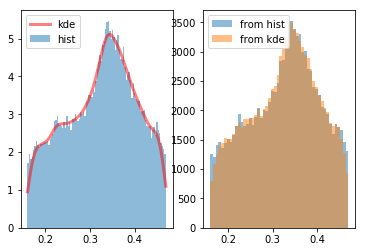

In [9]:
data=ascii.read("../output/DR7srarf.dat")
data = data['z']
hist, bins = np.histogram(data, bins=1000)
N=len(data)

x_grid = np.linspace(min(data), max(data), N)
kdepdf = kde(data, x_grid, bandwidth=0.01)
random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, N)

bin_midpoints = bins[:-1] + np.diff(bins) / 2
random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, N)

plt.subplot(121)
plt.hist(data, 100, normed=True, alpha=0.5, label='hist')
plt.plot(x_grid, kdepdf, color='r', alpha=0.5, lw=3, label='kde')
plt.legend()
plt.subplot(122)
plt.hist(random_from_cdf, 50, alpha=0.5, label='from hist')
plt.hist(random_from_kde, 50, alpha=0.5, label='from kde')
plt.legend()
plt.show()

In [10]:
random_from_kde

array([ 0.35675324,  0.19868791,  0.3470781 , ...,  0.2281322 ,
        0.32713906,  0.23911668])

In [11]:
len(random_from_kde)

105830

Read the data file (taken from http://cosmo.nyu.edu/~eak306/SDSS-LRG.html ) converted to ascii with comoving distance etc. in V01 reading from pkl files for faster read

In [4]:
# Getting back the objects:
with open('../output/datsLCDM.pkl') as f:  # Python 3: open(..., 'rb')
    dat = pickle.load(f)
dat

array([[ 0.402352,  0.980185, -0.003863],
       [ 0.335419,  1.016617,  0.003776],
       [ 0.373033,  0.950251,  0.010821],
       ..., 
       [ 0.310267,  2.829918,  0.173514],
       [ 0.336202,  2.830242,  0.172112],
       [ 0.209897,  2.831786,  0.173661]])

In [5]:
bins=np.arange(0.001,0.0801,0.001)

In [6]:
print bins

[ 0.001  0.002  0.003  0.004  0.005  0.006  0.007  0.008  0.009  0.01
  0.011  0.012  0.013  0.014  0.015  0.016  0.017  0.018  0.019  0.02
  0.021  0.022  0.023  0.024  0.025  0.026  0.027  0.028  0.029  0.03
  0.031  0.032  0.033  0.034  0.035  0.036  0.037  0.038  0.039  0.04
  0.041  0.042  0.043  0.044  0.045  0.046  0.047  0.048  0.049  0.05
  0.051  0.052  0.053  0.054  0.055  0.056  0.057  0.058  0.059  0.06
  0.061  0.062  0.063  0.064  0.065  0.066  0.067  0.068  0.069  0.07
  0.071  0.072  0.073  0.074  0.075  0.076  0.077  0.078  0.079  0.08 ]


In [7]:
Nbins=len(bins)

In [8]:
Nbins

80

In [9]:
%%time
BT_D = BallTree(dat,metric='pyfunc',func=LCDMmetricsq,leaf_size=5) 

with open('../pkl/BTDdatsLCDMsq.pkl', 'w') as f:
    pickle.dump(BT_D,f)

with open('../pkl/BTDdatsLCDMsq.pkl') as f:
    BTD = pickle.load(f)
    
BTD

CPU times: user 5.88 s, sys: 105 ms, total: 5.98 s
Wall time: 6.3 s


In [10]:
binsq=bins**2
binsq

array([  1.00000000e-06,   4.00000000e-06,   9.00000000e-06,
         1.60000000e-05,   2.50000000e-05,   3.60000000e-05,
         4.90000000e-05,   6.40000000e-05,   8.10000000e-05,
         1.00000000e-04,   1.21000000e-04,   1.44000000e-04,
         1.69000000e-04,   1.96000000e-04,   2.25000000e-04,
         2.56000000e-04,   2.89000000e-04,   3.24000000e-04,
         3.61000000e-04,   4.00000000e-04,   4.41000000e-04,
         4.84000000e-04,   5.29000000e-04,   5.76000000e-04,
         6.25000000e-04,   6.76000000e-04,   7.29000000e-04,
         7.84000000e-04,   8.41000000e-04,   9.00000000e-04,
         9.61000000e-04,   1.02400000e-03,   1.08900000e-03,
         1.15600000e-03,   1.22500000e-03,   1.29600000e-03,
         1.36900000e-03,   1.44400000e-03,   1.52100000e-03,
         1.60000000e-03,   1.68100000e-03,   1.76400000e-03,
         1.84900000e-03,   1.93600000e-03,   2.02500000e-03,
         2.11600000e-03,   2.20900000e-03,   2.30400000e-03,
         2.40100000e-03,

In [11]:
%%time
start_time=time.time()
counts_DD=BTD.two_point_correlation(dat,binsq)
print counts_DD
end_time=time.time()
tottime=end_time-start_time
print "Total run time:"
print tottime

with open('../pkl/BTDR72sDDLCDM.pkl', 'w') as f:
    pickle.dump(counts_DD,f)

[   120359    161290    218775    293390    389054    508471    657729
    836581   1053407   1309830   1612064   1961551   2364928   2827630
   3355304   3950137   4616908   5362000   6191387   7104872   8107724
   9210814  10415902  11727209  13147935  14683043  16336892  18110060
  20017428  22056497  24230687  26557413  29027844  31640018  34406049
  37329549  40409130  43648867  47058511  50636022  54388292  58311573
  62413549  66704196  71170633  75829823  80674283  85709067  90951344
  96373311 101985260 107812675 113839249 120062139 126504299 133149770
 140022402 147097820 154401439 161915340 169670590 177611901 185777031
 194169740 202779640 211622078 220705681 230018354 239572052 249368640
 259374682 269636247 280125617 290856761 301826910 313078370 324563356
 336309742 348290810 360519829]
Total run time:
1121.55524492
CPU times: user 18min 37s, sys: 2.19 s, total: 18min 39s
Wall time: 18min 41s


In [12]:
with open('../pkl/BTDR72sDDLCDM.pkl') as f:
    counts_DD = pickle.load(f)
    
counts_DD

array([   120359,    161290,    218775,    293390,    389054,    508471,
          657729,    836581,   1053407,   1309830,   1612064,   1961551,
         2364928,   2827630,   3355304,   3950137,   4616908,   5362000,
         6191387,   7104872,   8107724,   9210814,  10415902,  11727209,
        13147935,  14683043,  16336892,  18110060,  20017428,  22056497,
        24230687,  26557413,  29027844,  31640018,  34406049,  37329549,
        40409130,  43648867,  47058511,  50636022,  54388292,  58311573,
        62413549,  66704196,  71170633,  75829823,  80674283,  85709067,
        90951344,  96373311, 101985260, 107812675, 113839249, 120062139,
       126504299, 133149770, 140022402, 147097820, 154401439, 161915340,
       169670590, 177611901, 185777031, 194169740, 202779640, 211622078,
       220705681, 230018354, 239572052, 249368640, 259374682, 269636247,
       280125617, 290856761, 301826910, 313078370, 324563356, 336309742,
       348290810, 360519829])

In [14]:
DD=np.diff(counts_DD)
DD

array([   40931,    57485,    74615,    95664,   119417,   149258,
         178852,   216826,   256423,   302234,   349487,   403377,
         462702,   527674,   594833,   666771,   745092,   829387,
         913485,  1002852,  1103090,  1205088,  1311307,  1420726,
        1535108,  1653849,  1773168,  1907368,  2039069,  2174190,
        2326726,  2470431,  2612174,  2766031,  2923500,  3079581,
        3239737,  3409644,  3577511,  3752270,  3923281,  4101976,
        4290647,  4466437,  4659190,  4844460,  5034784,  5242277,
        5421967,  5611949,  5827415,  6026574,  6222890,  6442160,
        6645471,  6872632,  7075418,  7303619,  7513901,  7755250,
        7941311,  8165130,  8392709,  8609900,  8842438,  9083603,
        9312673,  9553698,  9796588, 10006042, 10261565, 10489370,
       10731144, 10970149, 11251460, 11484986, 11746386, 11981068, 12229019])

In [15]:
len(dat)

105830

BallTree.two_point_correlation works almost 10 times faster! with leaf_size=5 Going with it to the random catalog

In [16]:
# Getting back the objects:
with open('../output/datRs100kLCDM.pkl') as f:  # Python 3: open(..., 'rb')
    datR = pickle.load(f)
datR

array([[  3.99386000e-01,   3.50575800e+00,   5.25069000e-01],
       [  1.81160000e-01,   3.05099200e+00,   1.35846000e-01],
       [  2.90664000e-01,   2.71814000e+00,   2.41300000e-03],
       ..., 
       [  3.28141000e-01,   2.20094200e+00,   5.23620000e-02],
       [  2.32659000e-01,   2.95958900e+00,   1.14364000e-01],
       [  3.67697000e-01,   2.96577700e+00,   3.87508000e-01]])

In [17]:
%%time
BT_R = BallTree(dat,metric='pyfunc',func=LCDMmetricsq,leaf_size=5) 

with open('../pkl/BTRdatsLCDMsq.pkl', 'w') as f:
    pickle.dump(BT_R,f)

with open('../pkl/BTRdatsLCDMsq.pkl') as f:
    BTR = pickle.load(f)
    
BTR

CPU times: user 5.82 s, sys: 124 ms, total: 5.94 s
Wall time: 6.12 s


In [18]:
%%time
start_time=time.time()
counts_RR=BTR.two_point_correlation(datR,binsq)
print counts_RR
end_time=time.time()
tottime=end_time-start_time
print "Total run time:"
print tottime

with open('../pkl/BTRDR72100kRRLCDMsq.pkl', 'w') as f:
    pickle.dump(counts_RR,f)

with open('../pkl/BTRDR72100kRRLCDMsq.pkl') as f:
    counts_RR = pickle.load(f)
    
counts_RR

[      856      6868     22778     53022    102707    175892    278112
    412689    584420    798001   1057333   1365554   1729990   2154432
   2644393   3201884   3833172   4541419   5336165   6213636   7185698
   8256623   9429444  10707376  12094501  13596820  15215997  16956838
  18827403  20826667  22962718  25241300  27665203  30233374  32941518
  35806210  38830820  42016433  45370565  48889094  52572202  56430732
  60464225  64673158  69070603  73648870  78413295  83371016  88519999
  93872933  99399885 105140264 111073461 117223289 123574550 130121490
 136897063 143867851 151062052 158459131 166074450 173894077 181949649
 190221088 198720389 207449167 216389174 225561159 234984199 244594965
 254476253 264580730 274912619 285476794 296282727 307325575 318614973
 330151100 341929031 353942601]
Total run time:
1125.35932922
CPU times: user 18min 41s, sys: 2.35 s, total: 18min 43s
Wall time: 18min 45s


In [19]:
RR=np.diff(counts_RR)
RR

array([    6012,    15910,    30244,    49685,    73185,   102220,
         134577,   171731,   213581,   259332,   308221,   364436,
         424442,   489961,   557491,   631288,   708247,   794746,
         877471,   972062,  1070925,  1172821,  1277932,  1387125,
        1502319,  1619177,  1740841,  1870565,  1999264,  2136051,
        2278582,  2423903,  2568171,  2708144,  2864692,  3024610,
        3185613,  3354132,  3518529,  3683108,  3858530,  4033493,
        4208933,  4397445,  4578267,  4764425,  4957721,  5148983,
        5352934,  5526952,  5740379,  5933197,  6149828,  6351261,
        6546940,  6775573,  6970788,  7194201,  7397079,  7615319,
        7819627,  8055572,  8271439,  8499301,  8728778,  8940007,
        9171985,  9423040,  9610766,  9881288, 10104477, 10331889,
       10564175, 10805933, 11042848, 11289398, 11536127, 11777931, 12013570])

In [41]:
%%time
start_time=time.time()
counts_DR=BTD.two_point_correlation(datR,binsq)
end_time=time.time()
tottime=end_time-start_time
print "Total run time:"
print tottime

with open('../pkl/BTRDR72100kDRLCDMsq_.pkl', 'w') as f:
    pickle.dump(counts_DR,f)

Total run time:
1112.736691
CPU times: user 18min 26s, sys: 3.37 s, total: 18min 30s
Wall time: 18min 32s


In [42]:
with open('../pkl/BTRDR72100kDRLCDMsq_.pkl') as f:
    counts_DR = pickle.load(f)
counts_DR

array([      856,      6868,     22778,     53022,    102707,    175892,
          278112,    412689,    584420,    798001,   1057333,   1365554,
         1729990,   2154432,   2644393,   3201884,   3833172,   4541419,
         5336165,   6213636,   7185698,   8256623,   9429444,  10707376,
        12094501,  13596820,  15215997,  16956838,  18827403,  20826667,
        22962718,  25241300,  27665203,  30233374,  32941518,  35806210,
        38830820,  42016433,  45370565,  48889094,  52572202,  56430732,
        60464225,  64673158,  69070603,  73648870,  78413295,  83371016,
        88519999,  93872933,  99399885, 105140264, 111073461, 117223289,
       123574550, 130121490, 136897063, 143867851, 151062052, 158459131,
       166074450, 173894077, 181949649, 190221088, 198720389, 207449167,
       216389174, 225561159, 234984199, 244594965, 254476253, 264580730,
       274912619, 285476794, 296282727, 307325575, 318614973, 330151100,
       341929031, 353942601])

In [43]:
DR=np.diff(counts_DR)
DR

array([    6012,    15910,    30244,    49685,    73185,   102220,
         134577,   171731,   213581,   259332,   308221,   364436,
         424442,   489961,   557491,   631288,   708247,   794746,
         877471,   972062,  1070925,  1172821,  1277932,  1387125,
        1502319,  1619177,  1740841,  1870565,  1999264,  2136051,
        2278582,  2423903,  2568171,  2708144,  2864692,  3024610,
        3185613,  3354132,  3518529,  3683108,  3858530,  4033493,
        4208933,  4397445,  4578267,  4764425,  4957721,  5148983,
        5352934,  5526952,  5740379,  5933197,  6149828,  6351261,
        6546940,  6775573,  6970788,  7194201,  7397079,  7615319,
        7819627,  8055572,  8271439,  8499301,  8728778,  8940007,
        9171985,  9423040,  9610766,  9881288, 10104477, 10331889,
       10564175, 10805933, 11042848, 11289398, 11536127, 11777931, 12013570])

In [44]:
correl100k=(DD-2.0*DR+RR)/RR
correl100k

array([ 5.8082169 ,  2.61313639,  1.46710091,  0.92541008,  0.63171415,
        0.46016435,  0.32899381,  0.26259091,  0.200589  ,  0.16543273,
        0.13388445,  0.10685278,  0.09014188,  0.07697143,  0.06698225,
        0.05620731,  0.05202281,  0.04358751,  0.04104295,  0.03167493,
        0.03003478,  0.0275123 ,  0.02611641,  0.02422348,  0.02182559,
        0.02141335,  0.01856976,  0.0196748 ,  0.01990983,  0.01785491,
        0.02112893,  0.01919549,  0.01713398,  0.02137516,  0.02052856,
        0.01817457,  0.01699014,  0.01655033,  0.01676326,  0.01877816,
        0.01678126,  0.01697858,  0.01941442,  0.01568911,  0.01767547,
        0.01679846,  0.01554404,  0.01811892,  0.01289629,  0.01537864,
        0.01516207,  0.01573806,  0.01188033,  0.01431196,  0.01504993,
        0.01432484,  0.01500978,  0.01520919,  0.01579299,  0.01837494,
        0.01556136,  0.01360028,  0.01466129,  0.01301272,  0.0130213 ,
        0.01606218,  0.01533888,  0.0138658 ,  0.01933478,  0.01

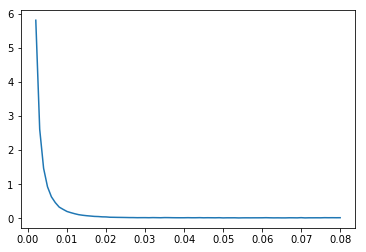

In [45]:
plt.plot(bins[1:len(bins)],correl100k)

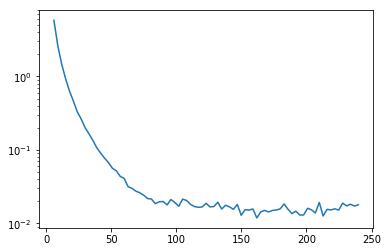

In [47]:
plt.yscale('log')
plt.plot(c*1e-5*bins[1:len(bins)],correl100k)

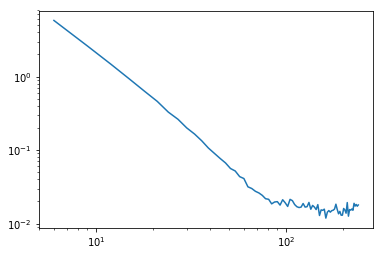

In [48]:
plt.xscale('log')
plt.yscale('log')
plt.plot(c*1e-5*bins[1:len(bins)],correl100k)

In [32]:
(DD*1.0/RR)

array([ 6.8082169 ,  3.61313639,  2.46710091,  1.92541008,  1.63171415,
        1.46016435,  1.32899381,  1.26259091,  1.200589  ,  1.16543273,
        1.13388445,  1.10685278,  1.09014188,  1.07697143,  1.06698225,
        1.05620731,  1.05202281,  1.04358751,  1.04104295,  1.03167493,
        1.03003478,  1.0275123 ,  1.02611641,  1.02422348,  1.02182559,
        1.02141335,  1.01856976,  1.0196748 ,  1.01990983,  1.01785491,
        1.02112893,  1.01919549,  1.01713398,  1.02137516,  1.02052856,
        1.01817457,  1.01699014,  1.01655033,  1.01676326,  1.01877816,
        1.01678126,  1.01697858,  1.01941442,  1.01568911,  1.01767547,
        1.01679846,  1.01554404,  1.01811892,  1.01289629,  1.01537864,
        1.01516207,  1.01573806,  1.01188033,  1.01431196,  1.01504993,
        1.01432484,  1.01500978,  1.01520919,  1.01579299,  1.01837494,
        1.01556136,  1.01360028,  1.01466129,  1.01301272,  1.0130213 ,
        1.01606218,  1.01533888,  1.0138658 ,  1.01933478,  1.01

In [35]:
(DR*1.0)/RR

array([ 6.8082169 ,  3.61313639,  2.46710091,  1.92541008,  1.63171415,
        1.46016435,  1.32899381,  1.26259091,  1.200589  ,  1.16543273,
        1.13388445,  1.10685278,  1.09014188,  1.07697143,  1.06698225,
        1.05620731,  1.05202281,  1.04358751,  1.04104295,  1.03167493,
        1.03003478,  1.0275123 ,  1.02611641,  1.02422348,  1.02182559,
        1.02141335,  1.01856976,  1.0196748 ,  1.01990983,  1.01785491,
        1.02112893,  1.01919549,  1.01713398,  1.02137516,  1.02052856,
        1.01817457,  1.01699014,  1.01655033,  1.01676326,  1.01877816,
        1.01678126,  1.01697858,  1.01941442,  1.01568911,  1.01767547,
        1.01679846,  1.01554404,  1.01811892,  1.01289629,  1.01537864,
        1.01516207,  1.01573806,  1.01188033,  1.01431196,  1.01504993,
        1.01432484,  1.01500978,  1.01520919,  1.01579299,  1.01837494,
        1.01556136,  1.01360028,  1.01466129,  1.01301272,  1.0130213 ,
        1.01606218,  1.01533888,  1.0138658 ,  1.01933478,  1.01

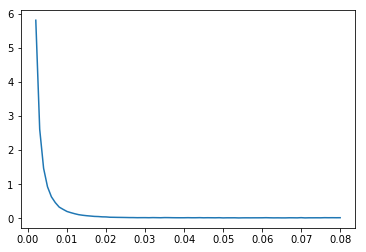

In [39]:
plt.plot(bins[1:len(bins)],(DR*1.0)/RR-1.0)

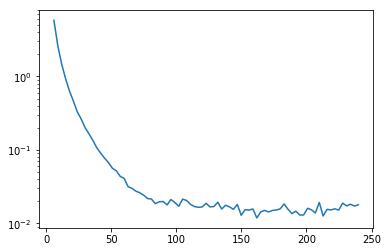

In [40]:
#plt.xscale('log')
plt.yscale('log')
plt.plot(c*1e-5*bins[1:len(bins)],(DR*1.0)/RR-1.0)

In [36]:
DD-DR

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [37]:
DD

array([   40931,    57485,    74615,    95664,   119417,   149258,
         178852,   216826,   256423,   302234,   349487,   403377,
         462702,   527674,   594833,   666771,   745092,   829387,
         913485,  1002852,  1103090,  1205088,  1311307,  1420726,
        1535108,  1653849,  1773168,  1907368,  2039069,  2174190,
        2326726,  2470431,  2612174,  2766031,  2923500,  3079581,
        3239737,  3409644,  3577511,  3752270,  3923281,  4101976,
        4290647,  4466437,  4659190,  4844460,  5034784,  5242277,
        5421967,  5611949,  5827415,  6026574,  6222890,  6442160,
        6645471,  6872632,  7075418,  7303619,  7513901,  7755250,
        7941311,  8165130,  8392709,  8609900,  8842438,  9083603,
        9312673,  9553698,  9796588, 10006042, 10261565, 10489370,
       10731144, 10970149, 11251460, 11484986, 11746386, 11981068, 12229019])

In [38]:
DR

array([   40931,    57485,    74615,    95664,   119417,   149258,
         178852,   216826,   256423,   302234,   349487,   403377,
         462702,   527674,   594833,   666771,   745092,   829387,
         913485,  1002852,  1103090,  1205088,  1311307,  1420726,
        1535108,  1653849,  1773168,  1907368,  2039069,  2174190,
        2326726,  2470431,  2612174,  2766031,  2923500,  3079581,
        3239737,  3409644,  3577511,  3752270,  3923281,  4101976,
        4290647,  4466437,  4659190,  4844460,  5034784,  5242277,
        5421967,  5611949,  5827415,  6026574,  6222890,  6442160,
        6645471,  6872632,  7075418,  7303619,  7513901,  7755250,
        7941311,  8165130,  8392709,  8609900,  8842438,  9083603,
        9312673,  9553698,  9796588, 10006042, 10261565, 10489370,
       10731144, 10970149, 11251460, 11484986, 11746386, 11981068, 12229019])

In [49]:
dataR=ascii.read("/Users/rohin/Downloads/random-DR7-Full.ascii")

In [50]:
dataREz = lambda x: 1/m.sqrt(0.3*(1+x)**3+0.7)

np.vectorize(Ez)
#Calculate comoving distance of a data point using the Redshift - This definition is based on the cosmology model we take. Here the distance for E-dS universe is considered. Also note that c/H0 ratio is cancelled in the equations and hence not taken.

def DC_LCDM(z):
    return integrate.quad(Ez, 0, z)[0]
DC_LCDM=np.vectorize(DC_LCDM)

dr12gcmn = open("../output/rdr12gcmnsrarf.dat",'w')
dr12gcmn.write("z\t ra\t dec\t s\t rar\t decr \n")

for i in range(0,len(zr)):
    dr12gcmn.write("%f\t " %zr[i])
    dr12gcmn.write("%f\t %f\t " %(rar[i],decr[i]))
    dr12gcmn.write("%f\t " %DC_LCDM(zr[i]))
    dr12gcmn.write("%f\t %f\n " %(rar[i]*pi/180.0,decr[i]*pi/180.0))
dr12gcmn.close()

col1,col2,col3,col4,col5,col6,col7,col8
float64,float64,float64,float64,float64,float64,int64,int64
37.837993,-0.620067,0.434325183323,1.0,5.3768849,1.9245105,28631,731
209.089259,17.276521,0.293264526407,1.0,12.5205946,0.8479636,607527,8282
258.464939,28.215748,0.222745622664,1.0,16.2676468,0.6556018,198135,2379
183.927141,37.379032,0.279300679012,1.0,12.5555115,0.8456514,467698,6459
170.682777,1.206543,0.324714480804,1.0,14.6967564,0.7245049,79476,323
172.780433,32.981495,0.365299949597,1.0,12.419775,0.8547112,519743,6242
154.275288,32.160072,0.431968131217,1.0,5.5194683,1.8769492,498622,6159
187.272243,16.128839,0.276107122388,1.0,12.6110067,0.8420024,447212,5607
130.655784,38.45825,0.24184703025,1.0,14.8485918,0.7172192,213332,2595


In [51]:
import pyfits
dataRf=pyfits.open("/Users/rohin/Downloads/random-DR7-Full.fits")
dataRf=dataRf[1].data
dataRf.columns

ColDefs(
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'ILSS'; format = 'J'
    name = 'EBV'; format = 'E'
    name = 'SECTOR'; format = 'J'
    name = 'Z'; format = 'D'
    name = 'SECTOR_COMPLETENESS'; format = 'E'
    name = 'COMOV_DENSITY'; format = 'E'
    name = 'RADIAL_WEIGHT'; format = 'E'
)

In [52]:
z=dataRf['Z']
ra=dataRf['RA']
dec=dataRf['DEC']

In [53]:
Ez = lambda x: 1/m.sqrt(0.3*(1+x)**3+0.7)

np.vectorize(Ez)
#Calculate comoving distance of a data point using the Redshift - This definition is based on the cosmology model we take. Here the distance for E-dS universe is considered. Also note that c/H0 ratio is cancelled in the equations and hence not taken.

def DC_LCDM(z):
    return integrate.quad(Ez, 0, z)[0]
DC_LCDM=np.vectorize(DC_LCDM)

In [54]:
dr72r = open("../output/DR72srandf16M.dat",'w')
dr72r.write("z\t ra\t dec\t s\t rar\t decr \n")

for i in range(0,len(z)):
    dr72r.write("%f\t " %z[i])
    dr72r.write("%f\t %f\t " %(ra[i],dec[i]))
    dr72r.write("%f\t " %DC_LCDM(z[i]))
    dr72r.write("%f\t %f\n " %(ra[i]*pi/180.0,dec[i]*pi/180.0))
dr72r.close()

In [55]:
z

array([ 0.43432518,  0.29326453,  0.22274562, ...,  0.29215485,
        0.18659366,  0.30794795])

In [56]:
dataR=ascii.read("../output/DR72srandf16M.dat")

In [57]:
dataR

z,ra,dec,s,rar,decr
float64,float64,float64,float64,float64,float64
0.434325,37.837993,-0.620067,0.389815,0.660398,-0.010822
0.293265,209.089259,17.276521,0.273097,3.649296,0.301532
0.222746,258.464939,28.215748,0.211182,4.511064,0.492458
0.279301,183.927141,37.379032,0.261027,3.210134,0.652387
0.324714,170.682777,1.206543,0.299939,2.978976,0.021058
0.3653,172.780433,32.981495,0.333879,3.015587,0.575636
0.431968,154.275288,32.160072,0.387941,2.692612,0.561299
0.276107,187.272243,16.128839,0.258254,3.268517,0.281501
0.241847,130.655784,38.45825,0.22819,2.280374,0.671223


In [58]:
dataR.remove_column('z')
dataR.remove_column('ra')
dataR.remove_column('dec')

In [59]:
dataR

s,rar,decr
float64,float64,float64
0.389815,0.660398,-0.010822
0.273097,3.649296,0.301532
0.211182,4.511064,0.492458
0.261027,3.210134,0.652387
0.299939,2.978976,0.021058
0.333879,3.015587,0.575636
0.387941,2.692612,0.561299
0.258254,3.268517,0.281501
0.22819,2.280374,0.671223


In [60]:
rs=np.array(dataR['s'])
rrar=np.array(dataR['rar'])
rdecr=np.array(dataR['decr'])

In [61]:
datR=np.array([rs,rrar,rdecr])

In [62]:
datR

array([[ 0.389815,  0.273097,  0.211182, ...,  0.272141,  0.178512,
         0.285688],
       [ 0.660398,  3.649296,  4.511064, ...,  4.011417,  2.318492,
         3.358066],
       [-0.010822,  0.301532,  0.492458, ...,  0.570892,  0.622178,
         0.761169]])

In [63]:
datR.reshape(3,len(dataR))

array([[ 0.389815,  0.273097,  0.211182, ...,  0.272141,  0.178512,
         0.285688],
       [ 0.660398,  3.649296,  4.511064, ...,  4.011417,  2.318492,
         3.358066],
       [-0.010822,  0.301532,  0.492458, ...,  0.570892,  0.622178,
         0.761169]])

In [64]:
datR=datR.transpose()

In [65]:
datR

array([[ 0.389815,  0.660398, -0.010822],
       [ 0.273097,  3.649296,  0.301532],
       [ 0.211182,  4.511064,  0.492458],
       ..., 
       [ 0.272141,  4.011417,  0.570892],
       [ 0.178512,  2.318492,  0.622178],
       [ 0.285688,  3.358066,  0.761169]])

In [66]:
# Saving the objects:
with open('../pkl/datRs16MLCDM.pkl', 'w') as f:  # Python 3: open(..., 'wb')
    pickle.dump(datR, f)

In [67]:
%%time
BT_R2 = BallTree(datR,metric='pyfunc',func=LCDMmetricsq,leaf_size=5) 

with open('../pkl/BTR16MdatsLCDM.pkl', 'w') as f:
    pickle.dump(BT_R2,f)

with open('../pkl/BTR16MdatsLCDM.pkl') as f:
    BTR = pickle.load(f)
    
BTR

CPU times: user 1min 55s, sys: 1.79 s, total: 1min 57s
Wall time: 2min 2s


In [68]:
len(datR)

1664948

In [ ]:
%%time
start_time=time.time()
counts_RR=BTR.two_point_correlation(datR,binsq)
print counts_RR
end_time=time.time()
tottime=end_time-start_time
print "Total run time:"
print tottime

with open('../pkl/BTR16MRRLCDM.pkl', 'w') as f:
    pickle.dump(counts_RR,f)

In [ ]:
with open('../pkl/BTR16MRRLCDM.pkl') as f:
    counts_RR = pickle.load(f)
    
counts_RR

In [ ]:
RR=np.diff(counts_RR)
RR

In [36]:
RR

array([  139377,   803560,  2102351,  3960581,  6349344,  9251810,
       12621537, 16427774, 20635566, 25206739, 30105486, 35269644,
       40719173, 46354660, 52146428])

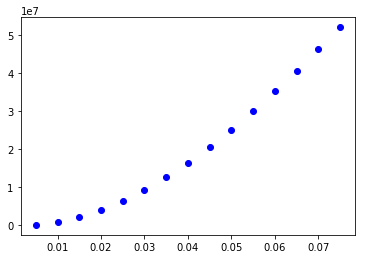

In [40]:
plt.plot(bins[1:len(bins)],RR,'bo')

In [53]:
RR_zero = (RR == 0)
RR[RR_zero] = 1

In [54]:
correl=1.0*DD/RR-1.0

In [55]:
correl

array([ 1.35830876,  0.28122978,  0.08986654,  0.04728624,  0.03223924,
        0.02651578,  0.02913773,  0.02925552,  0.02856214,  0.02910658,
        0.02825571,  0.02974039,  0.02806518,  0.02901232,  0.02976213])

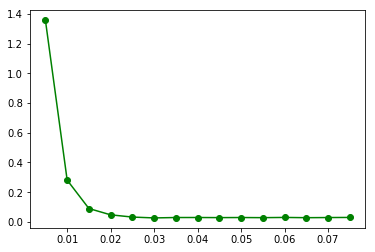

In [64]:
plt.plot(bins[1:len(bins)],correl,'go-')

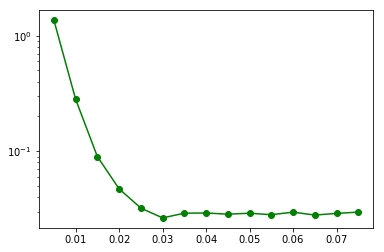

In [67]:
plt.yscale('log')
plt.plot(bins[1:len(bins)],correl,'go-')

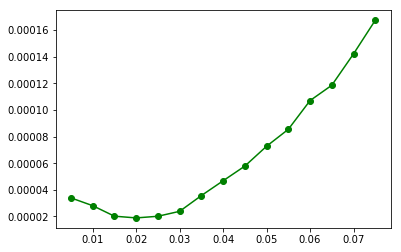

In [63]:
plt.plot(bins[1:len(bins)],bins[1:len(bins)]**2*correl,'go-')

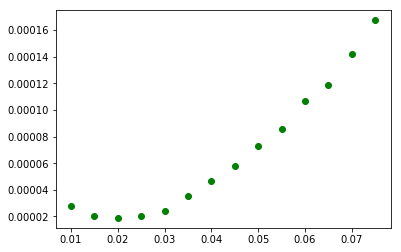

In [58]:
plt.plot(bins[2:len(bins)],bins[2:len(bins)]*bins[2:len(bins)]*correl[1:len(bins)],'go')

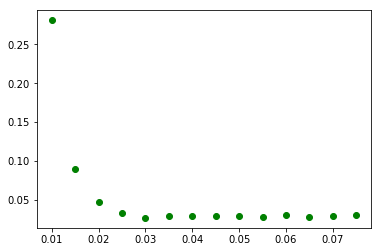

In [59]:
plt.plot(bins[2:len(bins)],correl[1:len(bins)],'go')

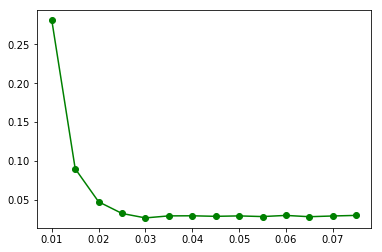

In [60]:
plt.plot(bins[2:len(bins)],correl[1:len(bins)],'go-')
plt.savefig("correl1.pdf")

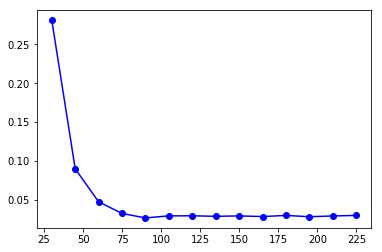

In [61]:
plt.plot(bins[2:len(bins)]*299792.458/100,correl[1:len(bins)],'bo-')

In [ ]:
start_time=time.time()
arg=[(dat,bins)]
pool=mp.Pool(8)
#%timeit
#@pickle_results("DR72DD2ptc.pkl")
def mf_wrap(args):
    return BTD.two_point_correlation(*args)

%timeit counts_DD=pool.map(mf_wrap,arg)

end_time=time.time()
tottime=end_time-start_time
print "Total run time:"
print tottime

In [ ]:
from functools import partial

def harvester(text, case):
    X = case[0]
    return text + str(X)


partial_harvester = partial(harvester, case=RAW_DATASET)

partial_qr=partial(BTD.query_radius,count_only=True)

if __name__ == '__main__':
    pool = multiprocessing.Pool(processes=6)
    case_data = RAW_DATASET
    pool.map(partial_harvester, case_data, 1)
    pool.close()
    pool.join()

mapfunc = partial(BTD.query_radius, count_only=True)
map(mapfunc, volume_ids)


In [ ]:
#ascii.write("DR72DDbinned.dat",(bins[1:len(bins)],DDresult))
start_time=time.time()
@pickle_results("DR72DDmp1.pkl")
def ddcal(BTD,dat,bins,Nbins):
    counts_DD=np.zeros(Nbins)
    for i in tqdm(range(Nbins)):
        counts_DD[i]=np.sum(BTD.query_radius(dat, bins[i],count_only=True))
    DD = np.diff(counts_DD)
    print counts_DD
    print DD
    return DD

def mf_wrap(args):
    return ddcal(*args)

pool=mp.Pool(8)

arg=[(BTD,dat,bins,Nbins)]
%timeit DDresult=pool.map(mf_wrap,arg) 
#DDresult = ddcal(BTD,dat,bins,Nbins)
end_time=time.time()
tottime=end_time-start_time
print "Total run time:"
print tottime

In [ ]:
%timeit dat

In [ ]:
DDresult[0]

In [ ]:
DDresult[1]

In [ ]:
plt.plot(bins[1:len(bins)],DDresult[0],'ro')

In [ ]:
def myfun(a,b):
  print a + b
  return a+b

def mf_wrap(args):
  return myfun(*args)

p = mp.Pool(4)

fl = [(a,b) for a in range(3) for b in range(2)]

p.map(mf_wrap, fl)

In [ ]:
counts_DD=np.zeros(Nbins)

for i in range(Nbins):
    counts_DD[i]=np.sum(BTD.query_radius(dat, bins[i],count_only=True))
DD = np.diff(counts_DD)

In [ ]:
print counts_DD
print DD

In [ ]:
plt.plot(bins[1:len(bins)],DD,'ro')

In [ ]:
dataR=fits.open("/Users/rohin/Downloads/random-DR7-Full.fits")

In [ ]:
dataR=dataR[1].data

In [ ]:
len(dataR)

In [ ]:
tdata=np.array(data)

In [ ]:
type(tdata[4])

In [ ]:
tdata.shape

In [ ]:
tdata.shape

In [ ]:
tdata=np.atleast_d(tdata)

In [ ]:
tdata.shape

In [ ]:
tdata.reshape(len(tdata),3)

In [ ]:
tdata=np.asarray(data)
tdata=tdata.transpose()

In [ ]:
tdata

In [ ]:
len(tdata)

In [ ]:
BTD.two_point_correlationpoint_correlationpoint_correlationpoint_correlationtime
stime=time.time()
tpcf=BTD.two_point_correlation(dat,bins)
print time.time()-stime
print tpcf
plt.plot(bins,tpcf)

In [ ]:
stime=time.time()
tpcfd=BTD.two_point_correlation(dat,bins,dualtree=True)
print time.time()-stime
print tpcfd
plt.plot(bins,tpcfd)

In [ ]:
X

In [ ]:
np.random.seed(0)
X = np.random.random((30,3))
r = np.linspace(0, 1, 10)
tree = BallTree(X,metric='pyfunc',func=LCDMmetric)                
s = pickle.dumps(tree)                     
treedump = pickle.loads(s) 
treedump.two_point_correlation(X,r)

In [ ]:
BT_D = BallTree(data)
        BT_R = BallTree(data_R)

        counts_DD = np.zeros(Nbins + 1)
        counts_RR = np.zeros(Nbins + 1)

        for i in range(Nbins + 1):
            counts_DD[i] = np.sum(BT_D.query_radius(data, bins[i],
                                                    count_only=True))
            counts_RR[i] = np.sum(BT_R.query_radius(data_R, bins[i],
                                                    count_only=True))

    DD = np.diff(counts_DD)
    RR = np.diff(counts_RR)

    # check for zero in the denominator
    RR_zero = (RR == 0)
    RR[RR_zero] = 1

    if method == 'standard':
        corr = factor ** 2 * DD / RR - 1
    elif method == 'landy-szalay':
        if sklearn_has_two_point:
            counts_DR = KDT_R.two_point_correlation(data, bins)
        else:
            counts_DR = np.zeros(Nbins + 1)
            for i in range(Nbins + 1):
                counts_DR[i] = np.sum(BT_R.query_radius(data, bins[i],
                                                        count_only=True))
        DR = np.diff(counts_DR)

        corr = (factor ** 2 * DD - 2 * factor * DR + RR) / RR

    corr[RR_zero] = np.nan

    return corr

In [ ]:
dr7fdat=np.array([data['s'][0:300] data['rar'][0:300] data['decr'][0:300]])
dr7fdat

In [ ]:
dr7fdat[2]

In [ ]:
def LCDMmetric(p1,p2):
    costheta=m.sin(dec1)*m.sin(dec2)+m.cos(dec1)*m.cos(dec2)*m.cos(ra1-ra2)
    s1=DC_LCDM(z1)
    s2=DC_LCDM(z2)
    return np.sqrt(s1**2+s2**2-2.0*s1*s2*costheta)

In [ ]:
#fdata=fits.open("/Users/rohin/Downloads/DR7-Full.fits")

In [ ]:
#fdata.writeto("./output/DR7fulltrim.fits")

In [ ]:
fdata=fits.open("./output/DR7fulltrim.fits")

In [ ]:
cols=fdata[1].columns

In [ ]:
cols.del_col('ZTYPE')

In [ ]:
cols.del_col('SECTOR')
cols.del_col('FGOTMAIN')
cols.del_col('QUALITY')
cols.del_col('ISBAD')
cols.del_col('M')
cols.del_col('MMAX')
cols.del_col('ILSS')
cols.del_col('ICOMB')
cols.del_col('VAGC_SELECT')
cols.del_col('LSS_INDEX')
cols.del_col('FIBERWEIGHT')
cols.del_col('PRIMTARGET')
cols.del_col('MG')
cols.del_col('SECTOR_COMPLETENESS')
cols.del_col('COMOV_DENSITY')
cols.del_col('RADIAL_WEIGHT')

In [ ]:
fdata[1].columns

In [ ]:
fdata.writeto("./output/DR7fullzradec.fits")

In [ ]:
fdat=fits.open("./output/DR7fullzradec.fits")

In [ ]:
fdat[1].columns

In [ ]:
fdat[1].data['Z']

In [ ]:
fdat[1].data['RA']

In [ ]:
comovlcdm=DC_LCDM(fdat[1].data['Z'])

In [ ]:
fdat[1].data['Z']

In [ ]:
comovlcdm

In [ ]:
comovlcdm.dtype

In [ ]:
#cols=fdat[1].columns

In [ ]:
nc=fits.Column(name='COMOV',format='D',array=comovlcdm)

In [ ]:
nc1=fits.Column(name='COMOV',format='D')

In [ ]:
fdata[1].data['Z']

In [ ]:
fdata[1].data['RA']

In [ ]:
nc

In [ ]:
nc.dtype

In [ ]:
#cols.add_col(nc)

In [ ]:
fdat[1].columns

In [ ]:
fdat[1].columns.info()

In [ ]:
fdat[1].columns.add_col(nc1)

In [ ]:
fdat[1].data['COMOV']=comovlcdm

In [ ]:
comovlcdm

In [ ]:
fdat[1].data['Z']

In [ ]:
fdat[1].data['COMOV']

In [ ]:
fdat[1].data['RA']

In [ ]:
fdat[1].data['RA']=fdat[1].data['RA']*pi/180.0

In [ ]:
comovlcdm=DC_LCDM(fdat[1].data['Z'])
comovlcdm

Random catalog created based on the survey limitations also taken from http://cosmo.nyu.edu/~eak306/SDSS-LRG.html

In [ ]:
dataR=fits.open("/Users/rohin/Downloads/random-DR7-Full.fits")

In [ ]:
dataR

In [ ]:
dataR=dataR[1].data

In [ ]:
len(dataR)

In [ ]:
NSIDE=512
dr72hpix=hu.HealPix("ring",NSIDE)

In [ ]:
pixdata = open("./output/pixdatadr72VAGCfullrand.dat",'w')
pixdata.write("z\t pix \n")

for i in range(0,len(data)-1):
    pixdata.write("%f\t" %data['z'][i])
    pixdata.write("%d\n" %dr72hpix.eq2pix(dataR['ra'][i],dataR['dec'][i]))
pixdata.close()

In [ ]:
pixdata = ascii.read("./output/pixdatadr72VAGCfullrand.dat")
hpixdata=np.array(np.zeros(hu.nside2npix(NSIDE)))
for j in range(len(pixdata)):
    hpixdata[pixdata[j]['pix']]+=1

In [ ]:
hpixdata

In [ ]:
hu.mollview(hpixdata,rot=180)

In [ ]:
hu.orthview(hpixdata)

In [ ]:
"""
Tools for computing two-point correlation functions.
"""

#from .utils import check_random_state
# From scikit-learn utilities:
def check_random_state(seed):
    """Turn seed into a np.random.RandomState instance

    If seed is None, return the RandomState singleton used by np.random.
    If seed is an int, return a new RandomState instance seeded with seed.
    If seed is already a RandomState instance, return it.
    Otherwise raise ValueError.
    """
    if seed is None or seed is np.random:
        return np.random.mtrand._rand
    if isinstance(seed, (int, np.integer)):
        return np.random.RandomState(seed)
    if isinstance(seed, np.random.RandomState):
        return seed
    raise ValueError('%r cannot be used to seed a numpy.random.RandomState'
                     ' instance' % seed)

# Check if scikit-learn's two-point functionality is available.
# This was added in scikit-learn version 0.14
try:
    from sklearn.neighbors import KDTree
    sklearn_has_two_point = True
except ImportError:
    import warnings
    sklearn_has_two_point = False


def uniform_sphere(RAlim, DEClim, size=1):
    """Draw a uniform sample on a sphere

    Parameters
    ----------
    RAlim : tuple
        select Right Ascension between RAlim[0] and RAlim[1]
        units are degrees
    DEClim : tuple
        select Declination between DEClim[0] and DEClim[1]
    size : int (optional)
        the size of the random arrays to return (default = 1)

    Returns
    -------
    RA, DEC : ndarray
        the random sample on the sphere within the given limits.
        arrays have shape equal to size.
    """
    zlim = np.sin(np.pi * np.asarray(DEClim) / 180.)

    z = zlim[0] + (zlim[1] - zlim[0]) * np.random.random(size)
    DEC = (180. / np.pi) * np.arcsin(z)
    RA = RAlim[0] + (RAlim[1] - RAlim[0]) * np.random.random(size)

    return RA, DEC


def ra_dec_to_xyz(ra, dec):
    """Convert ra & dec to Euclidean points

    Parameters
    ----------
    ra, dec : ndarrays

    Returns
    x, y, z : ndarrays
    """
    sin_ra = np.sin(ra * np.pi / 180.)
    cos_ra = np.cos(ra * np.pi / 180.)

    sin_dec = np.sin(np.pi / 2. - dec * np.pi / 180.)
    cos_dec = np.cos(np.pi / 2. - dec * np.pi / 180.)

    return (cos_ra * sin_dec,
            sin_ra * sin_dec,
            cos_dec)


def angular_dist_to_euclidean_dist(D, r=1):
    """convert angular distances to euclidean distances"""
    return 2 * r * np.sin(0.5 * D * np.pi / 180.)


def two_point(data, bins, method='standard',
              data_R=None, random_state=None):
    """Two-point correlation function

    Parameters
    ----------
    data : array_like
        input data, shape = [n_samples, n_features]
    bins : array_like
        bins within which to compute the 2-point correlation.
        shape = Nbins + 1
    method : string
        "standard" or "landy-szalay".
    data_R : array_like (optional)
        if specified, use this as the random comparison sample
    random_state : integer, np.random.RandomState, or None
        specify the random state to use for generating background

    Returns
    -------
    corr : ndarray
        the estimate of the correlation function within each bin
        shape = Nbins
    """
    data = np.asarray(data)
    bins = np.asarray(bins)
    rng = check_random_state(random_state)

    if method not in ['standard', 'landy-szalay']:
        raise ValueError("method must be 'standard' or 'landy-szalay'")

    if bins.ndim != 1:
        raise ValueError("bins must be a 1D array")

    if data.ndim == 1:
        data = data[:, np.newaxis]
    elif data.ndim != 2:
        raise ValueError("data should be 1D or 2D")

    n_samples, n_features = data.shape
    Nbins = len(bins) - 1

    # shuffle all but one axis to get background distribution
    if data_R is None:
        data_R = data.copy()
        for i in range(n_features - 1):
            rng.shuffle(data_R[:, i])
    else:
        data_R = np.asarray(data_R)
        if (data_R.ndim != 2) or (data_R.shape[-1] != n_features):
            raise ValueError('data_R must have same n_features as data')

    factor = len(data_R) * 1. / len(data)

    if sklearn_has_two_point:
        # Fast two-point correlation functions added in scikit-learn v. 0.14
        KDT_D = KDTree(data)
        KDT_R = KDTree(data_R)

        counts_DD = KDT_D.two_point_correlation(data, bins)
        counts_RR = KDT_R.two_point_correlation(data_R, bins)

    else:
        warnings.warn("Version 0.3 of astroML will require scikit-learn "
                      "version 0.14 or higher for correlation function "
                      "calculations. Upgrade to sklearn 0.14+ now for much "
                      "faster correlation function calculations.")

        BT_D = BallTree(data)
        BT_R = BallTree(data_R)

        counts_DD = np.zeros(Nbins + 1)
        counts_RR = np.zeros(Nbins + 1)

        for i in range(Nbins + 1):
            counts_DD[i] = np.sum(BT_D.query_radius(data, bins[i],
                                                    count_only=True))
            counts_RR[i] = np.sum(BT_R.query_radius(data_R, bins[i],
                                                    count_only=True))

    DD = np.diff(counts_DD)
    RR = np.diff(counts_RR)

    # check for zero in the denominator
    RR_zero = (RR == 0)
    RR[RR_zero] = 1

    if method == 'standard':
        corr = factor ** 2 * DD / RR - 1
    elif method == 'landy-szalay':
        if sklearn_has_two_point:
            counts_DR = KDT_R.two_point_correlation(data, bins)
        else:
            counts_DR = np.zeros(Nbins + 1)
            for i in range(Nbins + 1):
                counts_DR[i] = np.sum(BT_R.query_radius(data, bins[i],
                                                        count_only=True))
        DR = np.diff(counts_DR)

        corr = (factor ** 2 * DD - 2 * factor * DR + RR) / RR

    corr[RR_zero] = np.nan

    return corr


def bootstrap_two_point(data, bins, Nbootstrap=10,
                        method='standard', return_bootstraps=False,
                        random_state=None):
    """Bootstrapped two-point correlation function

    Parameters
    ----------
    data : array_like
        input data, shape = [n_samples, n_features]
    bins : array_like
        bins within which to compute the 2-point correlation.
        shape = Nbins + 1
    Nbootstrap : integer
        number of bootstrap resamples to perform (default = 10)
    method : string
        "standard" or "landy-szalay".
    return_bootstraps: bool
        if True, return full bootstrapped samples
    random_state : integer, np.random.RandomState, or None
        specify the random state to use for generating background

    Returns
    -------
    corr, corr_err : ndarrays
        the estimate of the correlation function and the bootstrap
        error within each bin. shape = Nbins
    """
    data = np.asarray(data)
    bins = np.asarray(bins)
    rng = check_random_state(random_state)

    if method not in ['standard', 'landy-szalay']:
        raise ValueError("method must be 'standard' or 'landy-szalay'")

    if bins.ndim != 1:
        raise ValueError("bins must be a 1D array")

    if data.ndim == 1:
        data = data[:, np.newaxis]
    elif data.ndim != 2:
        raise ValueError("data should be 1D or 2D")

    if Nbootstrap < 2:
        raise ValueError("Nbootstrap must be greater than 1")

    n_samples, n_features = data.shape

    # get the baseline estimate
    corr = two_point(data, bins, method=method, random_state=rng)

    bootstraps = np.zeros((Nbootstrap, len(corr)))

    for i in range(Nbootstrap):
        indices = rng.randint(0, n_samples, n_samples)
        bootstraps[i] = two_point(data[indices, :], bins, method=method,
                                  random_state=rng)

    # use masked std dev in case of NaNs
    corr_err = np.asarray(np.ma.masked_invalid(bootstraps).std(0, ddof=1))

    if return_bootstraps:
        return corr, corr_err, bootstraps
    else:
        return corr, corr_err


def two_point_angular(ra, dec, bins, method='standard', random_state=None):
    """Angular two-point correlation function

    A separate function is needed because angular distances are not
    euclidean, and random sampling needs to take into account the
    spherical volume element.

    Parameters
    ----------
    ra : array_like
        input right ascention, shape = (n_samples,)
    dec : array_like
        input declination
    bins : array_like
        bins within which to compute the 2-point correlation.
        shape = Nbins + 1
    method : string
        "standard" or "landy-szalay".
    random_state : integer, np.random.RandomState, or None
        specify the random state to use for generating background

    Returns
    -------
    corr : ndarray
        the estimate of the correlation function within each bin
        shape = Nbins
    """
    ra = np.asarray(ra)
    dec = np.asarray(dec)
    rng = check_random_state(random_state)

    if method not in ['standard', 'landy-szalay']:
        raise ValueError("method must be 'standard' or 'landy-szalay'")

    if bins.ndim != 1:
        raise ValueError("bins must be a 1D array")

    if (ra.ndim != 1) or (dec.ndim != 1) or (ra.shape != dec.shape):
        raise ValueError('ra and dec must be 1-dimensional '
                         'arrays of the same length')

    n_features = len(ra)
    Nbins = len(bins) - 1

    # draw a random sample with N points
    ra_R, dec_R = uniform_sphere((min(ra), max(ra)),
                                 (min(dec), max(dec)),
                                 2 * len(ra))

    data = np.asarray(ra_dec_to_xyz(ra, dec), order='F').T
    data_R = np.asarray(ra_dec_to_xyz(ra_R, dec_R), order='F').T

    # convert spherical bins to cartesian bins
    bins_transform = angular_dist_to_euclidean_dist(bins)

    return two_point(data, bins_transform, method=method,
                     data_R=data_R, random_state=rng)


def bootstrap_two_point_angular(ra, dec, bins, method='standard',
                                Nbootstraps=10, random_state=None):
    # type: (object, object, object, object, object, object) -> object
    """Angular two-point correlation function

    A separate function is needed because angular distances are not
    euclidean, and random sampling needs to take into account the
    spherical volume element.

    Parameters
    ----------
    ra : array_like
        input right ascention, shape = (n_samples,)
    dec : array_like
        input declination
    bins : array_like
        bins within which to compute the 2-point correlation.
        shape = Nbins + 1
    method : string
        "standard" or "landy-szalay".
    Nbootstraps : int
        number of bootstrap resamples
    random_state : integer, np.random.RandomState, or None
        specify the random state to use for generating background

    Returns
    -------
    corr : ndarray
        the estimate of the correlation function within each bin
        shape = Nbins
    dcorr : ndarray
        error estimate on dcorr (sample standard deviation of
        bootstrap resamples)
    bootstraps : ndarray
        The full sample of bootstraps used to compute corr and dcorr
    """
    ra = np.asarray(ra)
    dec = np.asarray(dec)
    rng = check_random_state(random_state)

    if method not in ['standard', 'landy-szalay']:
        raise ValueError("method must be 'standard' or 'landy-szalay'")

    if bins.ndim != 1:
        raise ValueError("bins must be a 1D array")

    if (ra.ndim != 1) or (dec.ndim != 1) or (ra.shape != dec.shape):
        raise ValueError('ra and dec must be 1-dimensional '
                         'arrays of the same length')

    n_features = len(ra)
    Nbins = len(bins) - 1
    data = np.asarray(ra_dec_to_xyz(ra, dec), order='F').T

    # convert spherical bins to cartesian bins
    bins_transform = angular_dist_to_euclidean_dist(bins)

    bootstraps = []

    for i in range(Nbootstraps):
        # draw a random sample with N points
        ra_R, dec_R = uniform_sphere((min(ra), max(ra)),
                                     (min(dec), max(dec)),
                                     2 * len(ra))

        data_R = np.asarray(ra_dec_to_xyz(ra_R, dec_R), order='F').T

        if i > 0:
            # random sample of the data
            ind = np.random.randint(0, data.shape[0], data.shape[0])
            data_b = data[ind]
        else:
            data_b = data

        bootstraps.append(two_point(data_b, bins_transform, method=method,
                                    data_R=data_R, random_state=rng))

    bootstraps = np.asarray(bootstraps)
    corr = np.mean(bootstraps, 0)
    corr_err = np.std(bootstraps, 0, ddof=1)

    return corr, corr_err, bootstraps

In [ ]:
sklearn_has_two_point

In [ ]:
help(KDTree)

In [ ]:
dataxyz=ra_dec_to_xyz(data['ra'],data['dec'])

In [ ]:
dataxyz=np.asarray(dataxyz)

In [ ]:
dataxyz=dataxyz.transpose()

In [ ]:
dataxyz

In [ ]:
dataxyzR=ra_dec_to_xyz(dataR['ra'],dataR['dec'])

In [ ]:
dataxyzR=np.asarray(dataxyzR)

In [ ]:
dataxyzR=dataxyzR.transpose()

In [ ]:
dataxyzR

In [ ]:
bins=np.arange(0.0,1.05,0.05)

In [ ]:
bins

In [ ]:
#@pickle_results("tpcf_std.pkl")
tpcf=two_point(dataxyz,bins,method='standard',data_R=dataxyzR, random_state=None)

In [ ]:
tpcf 

In [ ]:
plt.plot(bins[1:],tpcf,'ro')

In [ ]:
tpcfam=two_point(dataxyz,bins,method='standard',data_R=None, random_state=None)

In [ ]:
tpcfam

In [ ]:
plt.plot(bins[1:],tpcfam,'bo')

In [ ]:
bins2=np.arange(0.2,0.6,0.02)

In [ ]:
tpcfamb2=two_point(dataxyz,bins2,method='standard',data_R=None, random_state=None)

In [ ]:
plt.plot(bins2[1:],tpcfamb2,'go')

The above doesn't show any BAO feature... It used inbuilt astroML method to generate random catalog... by shuffling the original data's content... That way all of the random points fall in the same survey area and will adhere to all the filtering criteria... the factor or ratio of data pts vs. random pts will be 1... instead of large no. in case if we take existing random catalog or create one

In [ ]:
rng = check_random_state(None)

n_samples, n_features = dataxyz.shape
Nbins = len(bins) - 1

# shuffle all but one axis to get background distribution
data_Rxyz = dataxyz.copy()
print data_Rxyz
for i in range(n_features - 1):
    rng.shuffle(data_Rxyz[:, i])
print data_Rxyz

Lets see how it looks with a healpix map

In [ ]:
NSIDE=512
dr72hpix=hu.HealPix("ring",NSIDE)

In [ ]:
import math as m

def cart2sph(x,y,z):
    XsqPlusYsq = x**2 + y**2
    r = m.sqrt(XsqPlusYsq + z**2)               # r
    elev = m.atan2(z,m.sqrt(XsqPlusYsq))     # theta
    az = m.atan2(y,x)                           # phi
    return r, elev, az

def cart2sphA(pts):
    return np.array([cart2sph(x,y,z) for x,y,z in pts])

def appendSpherical(xyz):
    np.hstack((xyz, cart2sphA(xyz)))

In [ ]:
ang=cart2sphA(data_Rxyz)

In [ ]:
ang

In [ ]:
ang.shape

In [ ]:
#ang.resize((105831, 2))
np.squeeze(ang, axis=None)

In [ ]:
help(ang.squeeze)

In [ ]:
ang2=ang[:,1:]

In [ ]:
ang2

In [ ]:
ang2.shape

In [ ]:
ang2[2,0]

In [ ]:
pixdata = open("./output/pixdatadr72VAGCfullrandam.dat",'w')
pixdata.write("pix \n")
for i in range(0,len(ang2)-1):
    #pixdata.write("%f\t" %data['z'][i])
    pixdata.write("%d\n" %dr72hpix.ang2pix(ang2[i,0],ang2[i,1]))
pixdata.close()

In [ ]:
pixdata = ascii.read("./output/pixdatadr72VAGCfullrandam.dat")
hpixdata=np.array(np.zeros(hu.nside2npix(NSIDE)))
for j in range(len(pixdata)):
    hpixdata[pixdata[j]['pix']]+=1

In [ ]:
hpixdata

In [ ]:
hu.mollview(hpixdata,rot=180)

In [ ]:
hu.orthview(hpixdata)

This method doesnt seem to produce right random catalogs...doing it with ra and dec as follows

In [ ]:
data

In [ ]:
data['z'],data['ra'],data['dec']

In [ ]:
datzradec=np.array([data['z'], data['ra'], data['dec']])

In [ ]:
datzradec

In [ ]:
rng = check_random_state(None)

n_features, n_samples  = datzradec.shape

# shuffle all but one axis to get background distribution
data_Rzradec = datzradec.copy()
print data_Rzradec
for i in range(1,n_features):
    rng.shuffle(data_Rzradec[:, i])
print data_Rzradec

In [ ]:
min(data_Rzradec[:, 1])

In [ ]:
max(data_Rzradec[:, 1])

In [ ]:
min(data_Rzradec[:, 2])

In [ ]:
max(data_Rzradec[:, 2])

In [ ]:
min(datzradec[:, 1])

In [ ]:
max(datzradec[:, 1])

In [ ]:
min(datzradec[:, 2])

In [ ]:
max(datzradec[:, 2])

In [ ]:
range(1,3)

In [ ]:
help(rng.shuffle)

In [ ]:
n_samples

In [ ]:
n_features

In [ ]:
data_Rzradec

In [ ]:
data_Rzradec[0][2]

In [ ]:
len(data_Rzradec[0][:])

In [ ]:
data_Rzradec[0][:]

In [ ]:
pixdata = open("./output/pixdatadr72VAGCfullrandamrd.dat",'w')
pixdata.write("z\t pix \n")
for i in range(0,len(data_Rzradec[0][:])-1):
    pixdata.write("%f\t" %data_Rzradec[0][i])
    pixdata.write("%d\n" %dr72hpix.eq2pix(data_Rzradec[1][i],data_Rzradec[2][i]))
pixdata.close()

In [ ]:
pixdata = ascii.read("./output/pixdatadr72VAGCfullrandamrd.dat")
hpixdata=np.array(np.zeros(hu.nside2npix(NSIDE)))
for j in range(len(pixdata)):
    hpixdata[pixdata[j]['pix']]+=1

In [ ]:
hpixdata

In [ ]:
hu.mollview(hpixdata,rot=180)

In [ ]:
hu.orthview(hpixdata)

In [ ]:
dataxyz

In [ ]:
dataxyzR1=ra_dec_to_xyz(data_Rzradec[1][:],data_Rzradec[2][:])

In [ ]:
data_Rzradec[1][:]

In [ ]:
dataxyzR1

In [ ]:
dataxyzR1=np.asarray(dataxyzR1)

In [ ]:
dataxyzR1=dataxyzR1.transpose()

In [ ]:
dataxyzR1

In [ ]:
bins=np.arange(0.025,1.025,0.025)

In [ ]:
bins

In [ ]:
#@pickle_results("tpcf_std.pkl")
tpcf=two_point(dataxyz,bins,method='standard',data_R=dataxyzR1, random_state=None)

In [ ]:
tpcf 

In [ ]:
plt.plot(bins[1:],tpcf,'ro')

In [ ]:
bins=np.arange(0.0,1.05,0.05)

In [ ]:
#@pickle_results("tpcf_std.pkl")
tpcf=two_point(dataxyz,bins,method='standard',data_R=dataxyzR1, random_state=None)

In [ ]:
tpcf 

In [ ]:
plt.plot(bins[1:],tpcf,'ro')

In [ ]:
btpcf=bootstrap_two_point(dataxyz, bins, Nbootstrap=10,
                        method='standard', return_bootstraps=False,
                        random_state=None)

In [ ]:
btpcf

In [ ]:
plt.errorbar(bins[1:],btpcf[0],yerr=btpcf[1],fmt='ro-')

In [ ]:
help(plt.errorbar)

In [ ]:
@pickle_results("tpcf_ls.pkl")
tpcfls=two_point(dataxyz,bins,method='landy-szalay',
              data_R=dataxyzR, random_state=None)

In [ ]:
#------------------------------------------------------------
# Set up correlation function computation
#  This calculation takes a long time with the bootstrap resampling,
#  so we'll save the results.
@pickle_results("correlation_functionsdr72.pkl")
def compute_results(Nbins=16, Nbootstraps=10,  method='landy-szalay', rseed=0):
    np.random.seed(rseed)
    bins = 10 ** np.linspace(np.log10(1. / 60.), np.log10(6), 16)

    results = [bins]
    for D in [data]:
        results += bootstrap_two_point_angular(D['ra'],
                                               D['dec'],
                                               bins=bins,
                                               method=method,
                                               Nbootstraps=Nbootstraps)

    return results

(bins, r_corr, r_corr_err, r_bootstraps) = compute_results()

bin_centers = 0.5 * (bins[1:] + bins[:-1])

In [ ]:
bins

In [ ]:
r_corr

In [ ]:
r_corr_err

In [ ]:
r_bootstraps

In [ ]:
#------------------------------------------------------------
# Plot the results

label = '$0.15<z<0.25$\n$N=33813$' 

fig = plt.figure(figsize=(6, 6))
plt.xscale('log')
plt.yscale('log')
plt.errorbar(bin_centers, r_corr, r_corr_err,fmt='.k', ecolor='gray', lw=1)
fig.text(0.8, 0.8, label, ha='right', va='top')
plt.xlabel(r'$\theta\ (deg)$')
plt.ylabel(r'$w(\theta)$')
plt.show()

plt.show()
fig.savefig("wth_dr72015025.pdf")

In [ ]:
data=ascii.read('./input/sdssdr72_sorted_z.dat')

In [ ]:
data

In [ ]:
#m_max = 19

# redshift and magnitude cuts
data = data[data['z'] > 0.05]
data = data[data['z'] < 0.15]
#data = data[data['petroMag_r'] < m_max]

# RA/DEC cuts
RAmin, RAmax = 140, 220
DECmin, DECmax = 5, 45
data = data[data['ra'] < RAmax]
data = data[data['ra'] > RAmin]
data = data[data['dec'] < DECmax]
data = data[data['dec'] > DECmin]

#ur = data['modelMag_u'] - data['modelMag_r']
#flag_red = (ur > 2.22)
#flag_blue = ~flag_red

#datag 

print "data size:"
print "  total gals: ", len(data)
#print "  blue gals:", len(data_blue)

In [ ]:
NSIDE=512
dr72hpix=hu.HealPix("ring",NSIDE)

In [ ]:
pixdata = open("./output/pixdatadr72005015.dat",'w')
pixdata.write("z\t pix \n")

for i in range(0,len(data)-1):
    pixdata.write("%f\t" %data['z'][i])
    pixdata.write("%d\n" %dr72hpix.eq2pix(data['ra'][i],data['dec'][i]))
pixdata.close()

In [ ]:
pixdata = ascii.read("./output/pixdatadr72005015.dat")
hpixdata=np.array(np.zeros(hu.nside2npix(NSIDE)))
for j in range(len(pixdata)):
    hpixdata[pixdata[j]['pix']]+=1

In [ ]:
hpixdata

In [ ]:
hu.mollview(hpixdata,rot=180)

In [ ]:
hu.orthview(hpixdata)

In [ ]:
#------------------------------------------------------------
# Set up correlation function computation
#  This calculation takes a long time with the bootstrap resampling,
#  so we'll save the results.
@pickle_results("correlation_functionsdr720515.pkl")
def compute_results(Nbins=16, Nbootstraps=10,  method='landy-szalay', rseed=0):
    np.random.seed(rseed)
    bins = 10 ** np.linspace(np.log10(1. / 60.), np.log10(6), 16)

    results = [bins]
    for D in [data]:
        results += bootstrap_two_point_angular(D['ra'],
                                               D['dec'],
                                               bins=bins,
                                               method=method,
                                               Nbootstraps=Nbootstraps)

    return results

(bins, r_corr, r_corr_err, r_bootstraps) = compute_results()

bin_centers = 0.5 * (bins[1:] + bins[:-1])

In [ ]:
bins

In [ ]:
r_corr

In [ ]:
r_corr_err

In [ ]:
r_bootstraps

In [ ]:
#------------------------------------------------------------
# Plot the results
label = '$0.05<z<0.15$\n$N=138051$'

fig = plt.figure(figsize=(6, 6))
plt.xscale('log')
plt.yscale('log')
plt.errorbar(bin_centers, r_corr, r_corr_err,fmt='.k', ecolor='gray', lw=1)
fig.text(0.8, 0.8, label, ha='right', va='top')
plt.xlabel(r'$\theta\ (deg)$')
plt.ylabel(r'$w(\theta)$')
plt.show()
fig.savefig("wth_dr72005015.pdf")

In [ ]:
plt.errorbar(bins[0:len(bins)-1],r_corr,r_corr_err)

In [ ]:
data=ascii.read('./input/sdssdr72_sorted_z.dat')

In [ ]:
data

In [ ]:
data['z']

In [ ]:
#m_max = 19

# redshift and magnitude cuts
data = data[data['z'] > 0.05]
data = data[data['z'] <= 0.10]
#data = data[data['petroMag_r'] < m_max]

# RA/DEC cuts
RAmin, RAmax = 140, 220
DECmin, DECmax = 5, 45
data = data[data['ra'] < RAmax]
data = data[data['ra'] > RAmin]
data = data[data['dec'] < DECmax]
data = data[data['dec'] > DECmin]

#ur = data['modelMag_u'] - data['modelMag_r']
#flag_red = (ur > 2.22)
#flag_blue = ~flag_red

#datag 

print "data size:"
print "  total gals: ", len(data)
#print "  blue gals:", len(data_blue)

In [ ]:
NSIDE=512
dr72hpix=hu.HealPix("ring",NSIDE)

In [ ]:
pixdata = open("./output/pixdatadr7200501.dat",'w')
pixdata.write("z\t pix \n")

for i in range(0,len(data)-1):
    pixdata.write("%f\t" %data['z'][i])
    pixdata.write("%d\n" %dr72hpix.eq2pix(data['ra'][i],data['dec'][i]))
pixdata.close()

In [ ]:
pixdata = ascii.read("./output/pixdatadr7200501.dat")
hpixdata=np.array(np.zeros(hu.nside2npix(NSIDE)))
for j in range(len(pixdata)):
    hpixdata[pixdata[j]['pix']]+=1

In [ ]:
hpixdata

In [ ]:
hu.mollview(hpixdata,rot=180)

In [ ]:
hu.orthview(hpixdata)

In [ ]:
#------------------------------------------------------------
# Set up correlation function computation
#  This calculation takes a long time with the bootstrap resampling,
#  so we'll save the results.
@pickle_results("correlation_functionsdr720501.pkl")
def compute_results(Nbins=16, Nbootstraps=10,  method='landy-szalay', rseed=0):
    np.random.seed(rseed)
    bins = 10 ** np.linspace(np.log10(1. / 60.), np.log10(6), 16)

    results = [bins]
    for D in [data]:
        results += bootstrap_two_point_angular(D['ra'],
                                               D['dec'],
                                               bins=bins,
                                               method=method,
                                               Nbootstraps=Nbootstraps)

    return results

(bins, r_corr, r_corr_err, r_bootstraps) = compute_results()

bin_centers = 0.5 * (bins[1:] + bins[:-1])

In [ ]:
bins

In [ ]:
r_corr

In [ ]:
r_corr_err

In [ ]:
r_bootstraps

In [ ]:
#------------------------------------------------------------
# Plot the results

label = '$0.05<z<0.10$\n$N=78939$'

fig = plt.figure(figsize=(6, 6))
plt.xscale('log')
plt.yscale('log')
plt.errorbar(bin_centers, r_corr, r_corr_err,fmt='.k', ecolor='gray', lw=1)
fig.text(0.8, 0.8, label, ha='right', va='top')
plt.xlabel(r'$\theta\ (deg)$')
plt.ylabel(r'$w(\theta)$')
plt.show()
fig.savefig("wth_dr720501.pdf")

In [ ]:
plt.errorbar(bins[0:len(bins)-1],r_corr,r_corr_err)

In [ ]:
data=ascii.read('./input/sdssdr72_sorted_z.dat')

In [ ]:
data

In [ ]:
data['z']

In [ ]:
#m_max = 19

# redshift and magnitude cuts
data = data[data['z'] > 0.10]
data = data[data['z'] <= 0.15]
#data = data[data['petroMag_r'] < m_max]

# RA/DEC cuts
RAmin, RAmax = 140, 220
DECmin, DECmax = 5, 45
data = data[data['ra'] < RAmax]
data = data[data['ra'] > RAmin]
data = data[data['dec'] < DECmax]
data = data[data['dec'] > DECmin]

#ur = data['modelMag_u'] - data['modelMag_r']
#flag_red = (ur > 2.22)
#flag_blue = ~flag_red

#datag 

print "data size:"
print "  total gals: ", len(data)
#print "  blue gals:", len(data_blue)

In [ ]:
NSIDE=512
dr72hpix=hu.HealPix("ring",NSIDE)

In [ ]:
pixdata = open("./output/pixdatadr72001015.dat",'w')
pixdata.write("z\t pix \n")

for i in range(0,len(data)-1):
    pixdata.write("%f\t" %data['z'][i])
    pixdata.write("%d\n" %dr72hpix.eq2pix(data['ra'][i],data['dec'][i]))
pixdata.close()

In [ ]:
pixdata = ascii.read("./output/pixdatadr72001015.dat")
hpixdata=np.array(np.zeros(hu.nside2npix(NSIDE)))
for j in range(len(pixdata)):
    hpixdata[pixdata[j]['pix']]+=1

In [ ]:
hpixdata

In [ ]:
hu.mollview(hpixdata,rot=180)

In [ ]:
hu.orthview(hpixdata)

In [ ]:
#------------------------------------------------------------
# Set up correlation function computation
#  This calculation takes a long time with the bootstrap resampling,
#  so we'll save the results.
@pickle_results("correlation_functionsdr72001015.pkl")
def compute_results(Nbins=16, Nbootstraps=10,  method='landy-szalay', rseed=0):
    np.random.seed(rseed)
    bins = 10 ** np.linspace(np.log10(1. / 60.), np.log10(6), 16)

    results = [bins]
    for D in [data]:
        results += bootstrap_two_point_angular(D['ra'],
                                               D['dec'],
                                               bins=bins,
                                               method=method,
                                               Nbootstraps=Nbootstraps)

    return results

(bins, r_corr, r_corr_err, r_bootstraps) = compute_results()

bin_centers = 0.5 * (bins[1:] + bins[:-1])

In [ ]:
bins

In [ ]:
r_corr

In [ ]:
r_corr_err

In [ ]:
r_bootstraps

In [ ]:
#------------------------------------------------------------
# Plot the results

label = '$0.10<z<0.15$\n$N=59112$'
fig = plt.figure(figsize=(6, 6))
plt.xscale('log')
plt.yscale('log')
plt.errorbar(bin_centers, r_corr, r_corr_err,fmt='.k', ecolor='gray', lw=1)
fig.text(0.8, 0.8, label, ha='right', va='top')
plt.xlabel(r'$\theta\ (deg)$')
plt.ylabel(r'$w(\theta)$')
plt.show()
fig.savefig("wth_dr7201015.pdf")

In [ ]:
plt.errorbar(bins[0:len(bins)-1],r_corr,r_corr_err)

In [ ]:
hu.mollview(hpixdatab,rot=180)

In [ ]:
hu.orthview(hpixdatab)

In [ ]:
help(hu.mollview)

In [ ]:

from astroML.datasets import fetch_sdss_specgals
from astroML.correlation import bootstrap_two_point_angular

In [ ]:
help(bootstrap_two_point_angular)

In [ ]:
help(astroML.correlation)

In [ ]:
import astroML.correlation

In [ ]:
import sklearn.neighbors

In [ ]:
help(sklearn.neighbors)

Sorted and reduced column set data can now be 'read' to reduce RAM requirements of the table reading. 

In [ ]:
sdssdr72=ascii.read('./input/dssdr72_sorted_z.dat')

Create a healpix map with NSIDE=64 (no. of pixels = 49152 as $NPIX=12\times NSIDE^2$) because the no. of galaxies in the survey are less. For higher resolution (later for dr12) we will consider NSIDE=512 or even 1024. For now, we will create a 64 NSIDE map.

In [ ]:
NSIDE=64
dt72hpix=hu.HealPix("ring",NSIDE)

We have data of galaxies with redshifts between 0 and 0.5 ($0<z<0.5$). To look at a time slice/at a certain epoch we need to choose the list of galaxies within a redshift window. As, measurement of redshift has $\pm 0.05$ error. We can bin all the data into redshifts with range limited to 0.05 variation each. So, we have 10 databins with almost identical redshifts. We save each databin in a different file. 

In [ ]:
j=0
for i in range(1,17):
    pixdata = open("/home/rohin/Desktop/healpix/binned1/pixdata%d_%d.dat"%(NSIDE,i),'w')
    pixdata.write("ra\t dec\t z\t pix \n")
    #for j in range(len(sdssdr72)):
    try:
        while sdssdr72[j]['z']<0.03*i:
            pixdata.write("%f\t" %sdssdr72[j]['ra'])
            pixdata.write("%f\t" %sdssdr72[j]['dec'])
            pixdata.write("%f\t" %sdssdr72[j]['z'])
            pixdata.write("%d\n" %dt72hpix.eq2pix(sdssdr72[j]['ra'],sdssdr72[j]['dec']))
            #print dt72hpix.eq2pix(sdssdr72[j]['ra'],sdssdr72[j]['dec'])
            j=j+1
    except:
        pass
    pixdata.close()

In [ ]:
for i in range(1,17):
    pixdata = ascii.read("/home/rohin/Desktop/healpix/binned1/pixdata%d_%d.dat"%(NSIDE,i))
    mpixdata = open("/home/rohin/Desktop/healpix/binned1/masked/pixdata%d_%d.dat"%(NSIDE,i),'w')
    mpixdata.write("ra\t dec\t z\t pix \n")
    for j in range((len(pixdata)-1)):
        if 100<pixdata[j]['ra']<250:
            mpixdata.write("%f\t" %pixdata[j]['ra'])
            mpixdata.write("%f\t" %pixdata[j]['dec'])
            mpixdata.write("%f\t" %pixdata[j]['z'])
            mpixdata.write("%d\n" %pixdata[j]['pix'])
    #pixdata.write("/home/rohin/Desktop/healpix/binned1/masked/pixdata_%d.dat"%i,format='ascii')
                
                
            #print dt72hpix.eq2pix(sdssdr72[j]['ra'],sdssdr72[j]['dec'])
    mpixdata.close()

We now, take each databin and assign the total no. of galaxies as the value of each pixel. The following routine will calculate the no. of galaxies by couting the occurence of pixel numbers in the file.

In [ ]:
pixdata = ascii.read("/home/rohin/Desktop/healpix/binned1/masked/pixdata%d_2.dat"%NSIDE)
hpixdata=np.array(np.zeros(hu.nside2npix(NSIDE)))
for j in range(len(pixdata)):
    hpixdata[pixdata[j]['pix']]+=1

In [ ]:
hpixdata

In [ ]:
hu.orthview(hpixdata,rot=180)

In [ ]:
pixcl=hu.anafast(hpixdata,lmax=300)
ell = np.arange(len(pixcl))
plt.figure()
plt.plot(ell,np.log(pixcl))
plt.show()

In [ ]:
pixcl=hu.anafast(hpixdata,lmax=300)
ell = np.arange(len(pixcl))
plt.figure()
plt.plot(ell,np.sqrt(ell*(ell+1)*pixcl/(4*math.pi)))
plt.show()

In [ ]:
theta=np.arange(0,np.pi,0.001)

In [ ]:
correldat = np.polynomial.legendre.legval(np.cos(theta),(2*ell+1)*np.absolute(pixcl))/(4*math.pi)

In [ ]:
plt.figure()
plt.plot(theta[0:600]*180/math.pi,correldat[0:600])
plt.show()

In [ ]:
plt.figure()
plt.plot(theta*180/math.pi,correldat)
plt.show()

In [ ]:
randra,randdec=hu.randsphere(2200000)

In [ ]:
randhp=hu.HealPix("RING",NSIDE)

In [ ]:
randhppix=randhp.eq2pix(randra,randdec)

In [ ]:
randpixdat=np.array(np.zeros(hu.nside2npix(NSIDE)))

In [ ]:
for j in range(len(randhppix)):
    randpixdat[randhppix[j]]+=1

In [ ]:
randmaphp=hu.mollview(randpixdat)

In [ ]:
randcl=hu.anafast(randpixdat,lmax=300)
ell = np.arange(len(randcl))
plt.figure()
plt.plot(ell,np.sqrt(ell*(ell+1)*randcl/(4*math.pi)))
plt.show()

In [ ]:
correlrand = np.polynomial.legendre.legval(np.cos(theta),(2*ell+1)*np.absolute(randcl))/(4*math.pi)
plt.figure()
plt.plot(theta[0:600]*180/math.pi,correlrand[0:600])
plt.show()

In [ ]:
finalcorrel=correldat-correlrand
plt.figure()
plt.plot(theta[0:600]*180/math.pi,finalcorrel[0:600])
plt.show()

In [ ]:
finalpix=hpixdata-randpixdat

In [ ]:
hu.mollview(finalpix,rot=180)

In [ ]:
cl=hu.anafast(finalpix,lmax=300)
ell = np.arange(len(cl))
plt.figure()
plt.plot(ell,np.sqrt(ell*(ell+1)*cl/(4*math.pi)))
plt.show()

In [ ]:
correlrand = np.polynomial.legendre.legval(np.cos(theta),(2*ell+1)*np.absolute(cl))/(4*math.pi)
plt.figure()
plt.plot(theta[0:600]*180/math.pi,correlrand[0:600])
plt.show()

In [ ]:
finalcl=pixcl-randcl
correlrand = np.polynomial.legendre.legval(np.cos(theta),(2*ell+1)*np.absolute(finalcl))/(4*math.pi)
plt.figure()
plt.plot(theta[0:600]*180/math.pi,correlrand[0:600])
plt.show()

In [ ]:
help(fits)

In [ ]:
data[1].data['z']